<a href="https://colab.research.google.com/github/kekexin714/BME/blob/master/Kexin's_version_Structural_Annotation_of_RNA_Using_NMR_Chemical_Shifts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Structural Annotation of RNA Using NMR Chemical Shifts

# Manuscript Sketch

* **Introduction**:

1. RNA structure important
2. NMR probes structure
3. Chemical shifts in particular sensitive to structure
4. Highlight examples of structural parameters extracted from chemical shift data
5. Introduce the idea of structural annotation via NMR chemical shifts
  * base pairs
  * adjacent and non-adjacent stacking
  * syn vs. anti
  * solvent exposure
  * [pucker](https://www.youtube.com/watch?v=4VQxRKQcMYg)

6. Survey the use of machine learning used to predict structural parameter from NMR chemical shifts, for both proteins and RNA
7. Make point that most approaches previous approaches employed single task learning
8. Extol the virtues of multi-task learning
10. Summarize what we did and the results

* **Methods**:
1. Data set
2. MC-Annotate
3. Multi-task classifiers

* **Results**:
1. Model performance on test set (Macro-Analysis: e.g., ROC and concordance analysis) including impact of number of neighbors
2. Model performance on test set (Micro-Analysis); Compare, visually target and prediction, highlighting (and possibly explaning) errors.
3. Importance analysis (which chemical shifts are important for predicting each structural feature)




# Functions for input preparation
1.   Updated MC-Annotate input;
2.   get_data now takes a third argument for specifiying whether to use C or H or both chemical shifts;




In [0]:
RETAIN = ['id', 'resid', 'resname', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All', 'sasa', 'syn_anti', 'astack', 'nastack', 'pair', 'pucker', 'class']
RETAIN_NONAME = ['id', 'resid', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All', 'sasa', 'syn_anti', 'astack', 'nastack', 'pair', 'pucker', 'class']

def get_cs_all(cs_all, id):
	'''
	This function gets chemical shifts for a particular RNA.
	'''
	return(cs_all[cs_all.id == id])

def get_cs_residues(cs_i, resid, dummy=0, number_of_cs_types=19):
	'''
	This function return an array contining the chemical shifts 
	for a particular residues in an RNA.
	'''
	cs_tmp=cs_i[(cs_i.resid == resid)].drop(RETAIN, axis=1)
	info_tmp=cs_i[(cs_i.resid == resid)]
	if (cs_tmp.shape[0] != 1):
		return(dummy*np.ones(shape=(1, number_of_cs_types)))
	else:
		return(cs_tmp.values)

def get_resnames(cs_i, resid, dummy="UNK"):
	'''
	This function returns the residue name for specified residue (resid)
	'''
	cs_tmp=cs_i[(cs_i.resid == resid)]
	if (cs_tmp.shape[0] != 1):
		return(dummy)
	else:
		return(cs_tmp['resname'].values[0])

def get_cs_features(cs_i, resid, neighbors, number_of_cs_types):
	'''
	This function return chemical shifts and resnames for 
	residues (resid) and its neighbors
	'''
	cs=[]
	resnames=[]
	for i in range(resid-neighbors, resid+neighbors+1):
		cs.append(get_cs_residues(cs_i, resid=i, number_of_cs_types=number_of_cs_types))
		resnames.append(get_resnames(cs_i, i))
	return(resnames, np.array(cs))

def write_out_resname(neighbors=1):
	''' 
	Helper function that writes out the column names associated 
	resnames for a given residue and its neighbors
	'''  
	colnames = []
	for i in range(1-neighbors-1, neighbors+1):  # ['R-2', 'R-1', 'R', 'R+1', 'R+2'] when neighbors = 2
		if i < 0: 
			colnames.append('R%s'%i)
		elif i > 0: 
			colnames.append('R+%s'%i)
		else: 
			colnames.append('R')
	return(colnames)    

def get_cs_features_rna(cs, neighbors, number_of_cs_types):
	'''    
	This function generates the complete required data frame an RNA    
	'''
	all_features = []
	all_resnames = []
	for resid in cs['resid'].unique():
		resnames, features = get_cs_features(cs, resid, neighbors, number_of_cs_types)
		all_features.append(features.flatten())
		all_resnames.append(resnames)

	all_resnames = pd.DataFrame(all_resnames, dtype='object', columns = write_out_resname(neighbors))
	all_features = pd.DataFrame(all_features, dtype='object')
	info = pd.DataFrame(cs[RETAIN_NONAME].values, dtype='object', columns = RETAIN_NONAME)
	return(pd.concat([info, all_resnames, all_features], axis=1))

def get_cs_features_rna_all(cs, neighbors, number_of_cs_types):  
	'''    
	This function generate a pandas dataframe containing training data for all RNAs
	Each row in the data frame should contain the class and chemical shifts for given residue and neighbors in a given RNA.
	'''  
	cs_new=pd.DataFrame()
 	for pdbid in cs['id'].unique()[0 :]:
		tmp=get_cs_features_rna(get_cs_all(cs, id=pdbid), neighbors, number_of_cs_types)
		cs_new=pd.concat([cs_new, tmp], axis=0)
	return(cs_new)
 
def one_hot_encode(df, hot_columns):
  '''
    This function generate one hot encodes a dataFrame
    see: http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example 
  '''
  for hot_column in hot_columns:
    # use pd.concat to join the new columns with your original dataframe
    df = pd.concat([df, pd.get_dummies(df[hot_column], prefix=hot_column)],axis=1)
    # now drop the original 'country' column (you don't need it anymore)
    df.drop([hot_column],axis=1, inplace=True)
  return(df)

def balance_transformer(dataset):
    '''
      Copy of deepchem function for reweighting samples. 
      Deepchem version does not work.
    '''
    # Compute weighting factors from dataset.
    y = dataset.y
    w = dataset.w
    # Ensure dataset is binary
    np.testing.assert_allclose(sorted(np.unique(y)), np.array([0., 1.]))
    weights = []
    for ind, task in enumerate(dataset.get_task_names()):
      task_w = w[:]
      task_y = y[:]
      # Remove labels with zero weights
      task_y = task_y[task_w != 0]
      num_positives = np.count_nonzero(task_y)
      num_negatives = len(task_y) - num_positives
      if num_positives > 0:
        pos_weight = float(num_negatives) / num_positives
      else:
        pos_weight = 1
      neg_weight = 1
      weights.append((neg_weight, pos_weight)) 
    return(dc.data.NumpyDataset(X=dataset.X, y=dataset.y, w=np.where(y==1, pos_weight, neg_weight)))

def get_data(neighbors, training = True, partial = None):
  # load sasa data
  if training:    
    url="https://drive.google.com/uc?id=1Y3Imx-lTjGKCQAFqEKTbaMSzFARtwEFN&authuser=afrankz@umich.edu&usp=drive_fs"
  else:   
    url="https://drive.google.com/uc?id=1jLcowU89y4o5Xmv_qBs3VgZre5ZFFYwG&authuser=afrankz@umich.edu&usp=drive_fs"

  s=requests.get(url).content
  sasa=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = "\s+")
  print("[INFO]: SASA loaded data")
  print(sasa.head())

  # load cs data
  url="https://drive.google.com/uc?id=1ApGAKHnzKUjri-f_sSPZwqK5N3Cr7gPq&authuser=afrankz@umich.edu&usp=drive_fs" 
  s=requests.get(url).content
  cs=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = " ")

  # if partial = None, use both carbon and proton 
  # if partial = "C", use carbon chemical shifts only
  # if partial = "H", use proton chemical shifts only
  if partial == "C":
    cs.drop(columns=['H1p','H2p','H3p','H4p','H2','H5','H5p','H5pp','H6','H8'],inplace=True)
    number_of_cs_types = 9

  if partial == "H":
    cs.drop(columns=['C1p','C2p','C3p','C4p','C5p','C2','C5','C6','C8'],inplace=True)
    number_of_cs_types = 10

  if partial == None:
    number_of_cs_types = 19
  print("[INFO]: CS loaded data")
  #print(cs.head())

  # load MC-Annotate
  #url="https://drive.google.com/uc?id=1XV6zNRi6rnLNXpxRb6E9RGZ5ZPUnlI7O&authuser=kexin@umich.edu&usp=drive_fs" # comments: fixed some numbering issues, but url did not work 
  mc_annotate = pd.read_csv(DIR_PATH+"cs_structure.info", delim_whitespace=True, header=0)
  #url="https://drive.google.com/uc?id=1AY2tuleA7Q2yy5ID_YygIKPo2kR3EEH4&authuser=afrankz@umich.edu&usp=drive_fs" # cs_structure.info, columns = id resname resid sasa pucker syn_anti astack nastack pair
  #s=requests.get(url).content
  #mc_anontate=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = " ")
  #print("[INFO]: MC-Annotate loaded data")
  
  # merge sasa and cs
  data = pd.merge(cs, sasa, on=['id', 'resname', 'resid'])
  # merge with mc-annotate structure
  data = pd.merge(data, mc_annotate, on=['id', 'resname', 'resid'])  
  #drop_names = ['sugar_puckering', 'pseudoknot', 'junk']
  #data = data.drop(drop_names, axis=1)
  print("[INFO]: merged SASA, CS, and MC-Annotate")
  #print(data.head())

	# prepare for testing
  print(data.columns)
  data_all = get_cs_features_rna_all(data, neighbors = neighbors, number_of_cs_types = number_of_cs_types)
  print("[INFO]: Prepared final data set")
  #print(data_all.head())

  data_all = one_hot_encode(data_all, write_out_resname(neighbors)) # only encode resnames (including neighbors)
  print("[INFO]: One-hot encoded data")
  #print(data_all.head())
  return(data_all)

# Prepare input


In [0]:
################################################################
## Prepare data
################################################################
neighbors = 3
train = get_data(neighbors, training = True, partial="C") # partial = "C" or "H" or None
test = get_data(neighbors, training = False, partial="C")

In [0]:
'''
# Input checking
# 1. Check if train RNAs and test RNAs have similar sequences
train_RNAs = set(train.id.unique().tolist())
test_RNAs = set(test.id.unique().tolist())
train_RNAs.intersection(test_RNAs)

# 2. Check numbering
for rna in train.id.unique().tolist():
  x = train[train['id']==rna]
  if x.resid[0]!=1:
    print(rna) 
  # 2L8H(fixed), 2LDL, 2MNC(fixed), 2MXL, 5UZT(fixed)
'''

2N1Q vs 5WQ1?</br>
Used vsearch to check 4 test RNAs, no highly similar sequences in train set

In [0]:
# Prepare training set
sd_scale = 0.5
targets = ['sasa', 'astack',  'nastack', 'pair', 'syn_anti']
drop_names = ['id', 'resid', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All', 'sasa', 'astack',  'nastack', 'pair', 'syn_anti', 'pucker', 'class']
tmp_trainX = train.drop(drop_names, axis=1)
tmp_trainy = pd.DataFrame(train[targets].values, dtype = 'float', columns = targets)
trainX = pd.DataFrame(tmp_trainX.values, dtype = 'float')
trainy = tmp_trainy.values
train_mean = [trainy[:, 0].mean()] # mean of sasa
train_sd = [sd_scale*np.std(trainy[:, 0])]
tmp = one_hot_encode(pd.DataFrame(train['pucker'].values, columns=['pucker']), ['pucker'])
trainy_mix = np.vstack([ np.where(trainy[:, 0] <= train_mean[0]+train_sd[0], 0, 1),   # sasa threshold                 
                        trainy[:, 1], # astack
                        trainy[:, 2], # nastack
                        trainy[:, 3], # pair
                        trainy[:, 4], # syn_anti
                        tmp['pucker_C2p_endo'].values,
                        tmp['pucker_C3p_endo'].values,
                        tmp['pucker_C2p_exo'].values,
                        tmp['pucker_C3p_exo'].values,
                        tmp['pucker_C1p_exo'].values,
                        tmp['pucker_C4p_exo'].values
                        ]).T 
w = np.ones(len(trainy[:, 0]))
train_w = np.vstack([w, w, w, w, w, w, w, w, w, w, w]).T # weight is 1 for all cells
train_dataset = dc.data.NumpyDataset(trainX, trainy_mix, train_w) # use deepchem here, target weight

# Prepare test model
retain = ['id', 'resid', 'sasa']
tmp_testX = test.drop(drop_names, axis=1)
tmp_testy = pd.DataFrame(test[targets].values, dtype = 'float', columns = targets)
targets.append('pucker_C2p_endo')
targets.append('pucker_C3p_endo')
targets.append('pucker_C2p_exo')
targets.append('pucker_C3p_exo')
targets.append('pucker_C1p_exo')
targets.append('pucker_C4p_exo')

testX = pd.DataFrame(tmp_testX.values, dtype = 'float')
testy = tmp_testy.values
tmp = one_hot_encode(pd.DataFrame(test['pucker'].values, columns=['pucker']), ['pucker'])
testy_mix = np.vstack([ np.where(testy[:, 0] <= train_mean[0]+train_sd[0], 0, 1),                         
                        testy[:, 1],
                        testy[:, 2],
                        testy[:, 3],
                        testy[:, 4],
                        tmp['pucker_C2p_endo'].values,
                        tmp['pucker_C3p_endo'].values,
                        tmp['pucker_C2p_exo'].values,
                        tmp['pucker_C3p_exo'].values,
                        tmp['pucker_C1p_exo'].values,
                        tmp['pucker_C4p_exo'].values                       
                        ]).T
w = np.ones(len(testy[:, 0]))
test_w = np.vstack([w, w, w, w, w, w, w, w, w, w, w]).T
test_dataset = dc.data.NumpyDataset(np.array(testX), np.array(testy_mix), test_w)

info = pd.DataFrame(test[retain].values, dtype='object', columns = retain) # info is id, resid, and sasa
actuals = pd.DataFrame(testy_mix, columns=targets)

info.to_csv(DIR_PATH+'info.csv', sep = ' ',header=True,index=False)
actuals.to_csv(DIR_PATH+'actuals.csv', sep = ' ',header=True,index=False)

In [0]:
pd.DataFrame({"sasa":trainy_mix[:, 0], 
             "astack":trainy_mix[:, 1], 
             "nastack":trainy_mix[:, 2], 
             "pair":trainy_mix[:, 3], 
             "syn_anti":trainy_mix[:, 4], 
             "pucker_C2p_endo":trainy_mix[:, 5],
             "pucker_C3p_endo":trainy_mix[:, 6],
             "pucker_C2p_exo":trainy_mix[:, 7],
             "pucker_C3p_exo":trainy_mix[:, 8],
             "pucker_C1p_exo":trainy_mix[:, 9],
             "pucker_C4p_exo":trainy_mix[:, 10]}).to_csv(DIR_PATH+"train_target_3.csv", sep = " ", index = False)

trainX.to_csv(DIR_PATH+"train_features_3_carbon.csv", sep = " ", index = False) # where are these files?

pd.DataFrame({"sasa":testy_mix[:, 0], 
             "astack":testy_mix[:, 1], 
             "nastack":testy_mix[:, 2], 
             "pair":testy_mix[:, 3], 
             "syn_anti":testy_mix[:, 4], 
             "pucker_C2p_endo":testy_mix[:, 5],
             "pucker_C3p_endo":testy_mix[:, 6],
             "pucker_C2p_exo":testy_mix[:, 7],
             "pucker_C3p_exo":testy_mix[:, 8],
             "pucker_C1p_exo":testy_mix[:, 9],
             "pucker_C4p_exo":testy_mix[:, 10]}).to_csv(DIR_PATH+"test_target_3.csv", sep = " ", index = False)

testX.to_csv(DIR_PATH+"test_features_3_carbon.csv", sep = " ", index = False)

In [0]:
trainy = pd.DataFrame({"sasa":trainy_mix[:, 0], 
             "astack":trainy_mix[:, 1], 
             "nastack":trainy_mix[:, 2], 
             "pair":trainy_mix[:, 3], 
             "syn_anti":trainy_mix[:, 4], 
             "pucker_C2p_endo":trainy_mix[:, 5],
             "pucker_C3p_endo":trainy_mix[:, 6],
             "pucker_C2p_exo":trainy_mix[:, 7],
             "pucker_C3p_exo":trainy_mix[:, 8],
             "pucker_C1p_exo":trainy_mix[:, 9],
             "pucker_C4p_exo":trainy_mix[:, 10]})
testy = pd.DataFrame({"sasa":testy_mix[:, 0], 
             "astack":testy_mix[:, 1], 
             "nastack":testy_mix[:, 2], 
             "pair":testy_mix[:, 3], 
             "syn_anti":testy_mix[:, 4], 
             "pucker_C2p_endo":testy_mix[:, 5],
             "pucker_C3p_endo":testy_mix[:, 6],
             "pucker_C2p_exo":testy_mix[:, 7],
             "pucker_C3p_exo":testy_mix[:, 8],
             "pucker_C1p_exo":testy_mix[:, 9],
             "pucker_C4p_exo":testy_mix[:, 10]})

train_dist = trainy.apply(lambda x: x.value_counts(), axis=0)
test_dist = testy.apply(lambda x: x.value_counts(), axis=0)
train_dist.to_csv(DIR_PATH+"train_targets_dist.csv", header=True, index=True, sep = " ")
test_dist.to_csv(DIR_PATH+"test_targets_dist.csv", header=True, index=True, sep = " ")

# **Kexin's codes start from here...**

# Mount drive and load libraries

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
DIR_PATH = 'drive/My Drive/CS-Annotate/'

Mounted at /content/drive


In [0]:
!pip install scikit-multilearn
!apt-get -qq install -y python-rdkit librdkit1 rdkit-data
!pip install -q joblib sklearn tensorflow pillow deepchem

In [0]:
# plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from string import ascii_letters

# model selection 
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score,f1_score,balanced_accuracy_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import ClassifierChain # difference? yes, this does not support gridsearchcv, but supportes random state
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,cross_validate
from sklearn.multiclass import OneVsRestClassifier
#from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import classification_report,confusion_matrix

# deepchem
import rdkit as rd
import deepchem as dc
import tensorflow as tf

# other
import numpy as np
import pandas as pd 
import requests
import io

W0321 17:00:10.496474 140375581071232 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Load data and preprocess

In [0]:
 neighbors = 3
# load train and test data
X_train = pd.read_csv(DIR_PATH+"train_features_"+str(neighbors)+".csv",delim_whitespace=True,header=0)
y_train = pd.read_csv(DIR_PATH+"train_target_"+str(neighbors)+".csv",delim_whitespace=True,header=0)
X_test = pd.read_csv(DIR_PATH+"test_features_"+str(neighbors)+".csv",delim_whitespace=True,header=0)
y_test = pd.read_csv(DIR_PATH+"test_target_"+str(neighbors)+".csv",delim_whitespace=True,header=0)
targets = y_train.columns

# convert to deepchem dataset
w = np.ones(y_train.shape[0]) # number of samples in train
train_w = np.vstack([w, w, w, w, w, w, w, w, w, w, w]).T # weight is 1 
train_dataset = dc.data.NumpyDataset(X_train, y_train, train_w) # use deepchem here, some kind of weight

w = np.ones(y_test.shape[0]) # number of samples in test
test_w = np.vstack([w, w, w, w, w, w, w, w, w, w, w]).T # weight is 1 
test_dataset = dc.data.NumpyDataset(X_test, y_test, test_w) # use deepchem here, some kind of weight

# Scale
transform_scaler = dc.trans.transformers.NormalizationTransformer(transform_X = True, transform_y = False, dataset=train_dataset)
train_dataset_norm = transform_scaler.transform(train_dataset)
test_dataset_norm = transform_scaler.transform(test_dataset)

# Balance Dataset
transform_balancer = dc.trans.transformers.BalancingTransformer(transform_w = True, dataset=train_dataset_norm) # this will work, inconsistent names before
train_dataset_balanced = transform_balancer.transform(train_dataset_norm)

n_features = train_dataset_balanced.X.shape[1]
n_tasks = train_dataset_balanced.y.shape[1]

In [0]:
print(targets)
print(test_dataset.X.shape)

Index([u'astack', u'nastack', u'pair', u'pucker_C1p_exo', u'pucker_C2p_endo',
       u'pucker_C2p_exo', u'pucker_C3p_endo', u'pucker_C3p_exo',
       u'pucker_C4p_exo', u'sasa', u'syn_anti'],
      dtype='object')
(284, 119)


### Correlation between targets

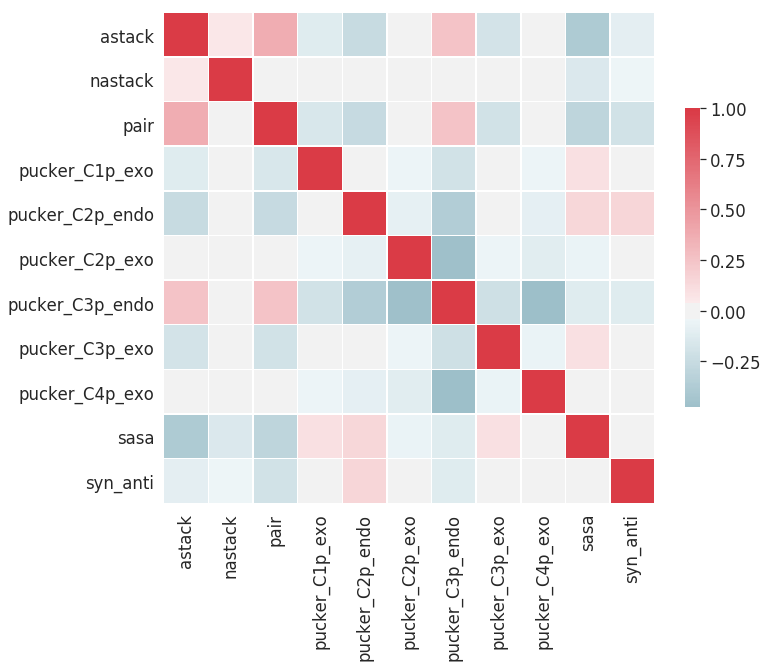

In [0]:
corr = y_train.corr()

sns.set(style="white",font_scale=1.5)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Model selection - cross validation
Notes: I used plotly to generate figure which is incompatible with python2, so I created another notebook for making figures.

## Method 1: K-Fold cross validation with MLP directly
Most naive way. It should have similar performance as the OVR predictors in Method 2.

In [0]:
X = train_dataset_balanced.X
y = train_dataset_balanced.y
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

print(kf)
list_score = []  
list_score_per_class= []

for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  clf = MLPClassifier(max_iter=1000) # increase iterations to ensure convergence
  clf.fit(X_train, y_train)
  preds = clf.predict(X_test)
  score = balanced_accuracy_score(y_test.flatten(),preds.flatten())
  list_score.append(score)
  list_temp =[]
  for i in range(11):
    score_per_class = balanced_accuracy_score(y_test[:,i], preds[:,i])
    list_temp.append(score_per_class)
  list_score_per_class.append(list_temp) 
print(list_score)
del score, list_temp, score_per_class

KFold(n_splits=5, random_state=None, shuffle=True)
[0.8169955890706462, 0.8068777771358817, 0.8193765287760094, 0.8167080689315496, 0.818642490197372]


In [0]:
list_score_per_class = pd.DataFrame(list_score_per_class)
list_score_per_class=list_score_per_class.append(list_score_per_class.apply(np.mean, axis = 0),ignore_index=True)
list_score_per_class.index=["cv1","cv2","cv3","cv4","cv5","mean"]
list_score_per_class.columns = targets
list_score_per_class.to_csv(DIR_PATH+"MLP_cv_balanced_accuracy.csv", index=True, sep=" ", header=True)

In [0]:
list_score_per_class

,astack,nastack,pair,pucker_C1p_exo,pucker_C2p_endo,pucker_C2p_exo,pucker_C3p_endo,pucker_C3p_exo,pucker_C4p_exo,sasa,syn_anti
cv1,0.683799,0.716598,0.707748,0.498148,0.595815,0.552394,0.612479,0.644444,0.543011,0.645094,0.666667
cv2,0.662925,0.649069,0.757041,0.494455,0.564355,0.548290,0.561234,0.532373,0.546703,0.694876,0.644444
cv3,0.668857,0.652770,0.773626,0.520031,0.662476,0.534343,0.627507,0.525857,0.492153,0.674575,0.803275
cv4,0.630799,0.715982,0.759496,0.591728,0.618761,0.550837,0.593605,0.594993,0.492062,0.648139,0.633576
cv5,0.651639,0.708260,0.747874,0.548145,0.695472,0.525301,0.619543,0.493506,0.566723,0.685783,0.791573
mean,0.659604,0.688536,0.749157,0.530501,0.627376,0.542233,0.602874,0.558235,0.528130,0.669693,0.707907


## Method 2: ChainClassifier with KFold cv
ChainClassifier uses predictions from previous tasks as input for subsequent training. Since we don't know the optimal ordering of tasks in advance, we could try random orderings and take the average prediction, to build an ensemble model.

In [0]:
def chain_classifier_ensemble(X_train, y_train, X_test, y_test, cv):
  # Fit an independent MLP classification model for each class using the
  # OneVsRestClassifier wrapper.
  base_lr = MLPClassifier(max_iter=1000)
  ovr = OneVsRestClassifier(base_lr)
  ovr.fit(X_train, y_train)
  Y_pred_ovr = ovr.predict_proba(X_test)
  # save ovr output for future analysis
  pd.DataFrame(Y_pred_ovr).to_csv(DIR_PATH+"chain/pred_ovr_cv_"+str(cv)+".csv",sep=" ",header=False,index=False)

  # save y_test
  pd.DataFrame(y_test).to_csv(DIR_PATH+"chain/y_test_cv_"+str(cv)+".csv",sep=" ",header=False,index=False)
  
  # Fit an ensemble of 10 MLP classifier chains and take the average prediction of all the chains.
  chains = [ClassifierChain(base_lr, order='random', random_state=i) for i in range(10)]
  for chain in chains:
      chain.fit(X_train, y_train)
  Y_pred_chains = np.array([chain.predict_proba(X_test) for chain in chains])
  
  # save Chain Classifier predictions
  for i in range(10):
    Y_pred_chain = Y_pred_chains[i]
    print("Chain "+str(i)+" for CV "+str(cv))
    pd.DataFrame(Y_pred_chain).to_csv(DIR_PATH+"chain/pred_chain_"+str(i)+"_cv_"+str(cv)+".csv",sep=" ",header=False,index=False)


  Y_pred_ensemble = Y_pred_chains.mean(axis=0)
  # save ensemble predictions
  pd.DataFrame(Y_pred_ensemble).to_csv(DIR_PATH+"chain/pred_ensemble_cv_"+str(cv)+".csv",sep=" ",header=False,index=False)

In [0]:
# classifier chain with cv
X = train_dataset_balanced.X
y = train_dataset_balanced.y
kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(X)

print(kf)
cv = 0
for train_index, test_index in kf.split(X):
    cv = cv+1
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    chain_classifier_ensemble(X_train, y_train, X_test, y_test, cv)

KFold(n_splits=5, random_state=None, shuffle=True)
Chain 0 for CV 1
Chain 1 for CV 1
Chain 2 for CV 1
Chain 3 for CV 1
Chain 4 for CV 1
Chain 5 for CV 1
Chain 6 for CV 1
Chain 7 for CV 1
Chain 8 for CV 1
Chain 9 for CV 1
Chain 0 for CV 2
Chain 1 for CV 2
Chain 2 for CV 2
Chain 3 for CV 2
Chain 4 for CV 2
Chain 5 for CV 2
Chain 6 for CV 2
Chain 7 for CV 2
Chain 8 for CV 2
Chain 9 for CV 2
Chain 0 for CV 3
Chain 1 for CV 3
Chain 2 for CV 3
Chain 3 for CV 3
Chain 4 for CV 3
Chain 5 for CV 3
Chain 6 for CV 3
Chain 7 for CV 3
Chain 8 for CV 3
Chain 9 for CV 3
Chain 0 for CV 4
Chain 1 for CV 4
Chain 2 for CV 4
Chain 3 for CV 4
Chain 4 for CV 4
Chain 5 for CV 4
Chain 6 for CV 4
Chain 7 for CV 4
Chain 8 for CV 4
Chain 9 for CV 4
Chain 0 for CV 5
Chain 1 for CV 5
Chain 2 for CV 5
Chain 3 for CV 5
Chain 4 for CV 5
Chain 5 for CV 5
Chain 6 for CV 5
Chain 7 for CV 5
Chain 8 for CV 5
Chain 9 for CV 5


## Method 3: Deepchem progressive neural networks

### Learning curve: how many epochs are enough?

In [0]:
def train_val_score(dataset, epoch):
  spliter = dc.splits.RandomSplitter()
  train_dataset, valid_dataset = spliter.train_test_split(train_dataset_balanced)
  print("Fit model....")
  # Fit trained model
  # use same architecture as MLP classifiers: # of neurons = 100, lr = 0.001
  model = dc.models.ProgressiveMultitaskClassifier(n_tasks=n_tasks,n_features=n_features,layer_sizes=[100],alpha_init_stddevs=0.04,learning_rate=0.001)
  model.fit(train_dataset, nb_epoch=epoch)
  print("Calculate scores....")
  # calculate validation score
  preds = model.predict(valid_dataset)
  score_val = accuracy_score(valid_dataset.y.flatten(), preds[:,:,1].flatten()>=0.5)
  preds_train = model.predict(train_dataset)
  score_train = accuracy_score(train_dataset.y.flatten(), preds_train[:,:,1].flatten()>=0.5)
  return score_val, score_train

In [0]:
epochs = [10,25,50,100]
#lrs = [0.00001,0.0001,0.001,0.01]
val = []
train = []
for epoch in epochs:
  val_tmp, train_tmp = train_val_score(train_dataset_balanced, epoch)
  val.append(val_tmp)
  train.append(train_tmp)

Fit model....
Calculate scores....
Fit model....
Calculate scores....
Fit model....
Calculate scores....
Fit model....
Calculate scores....


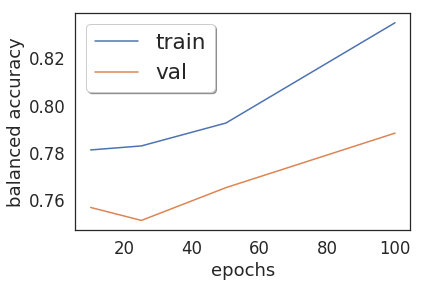

In [0]:
fig, ax = plt.subplots()
ax.plot(epochs, train, label='train')
ax.plot(epochs, val, label='val')
legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
plt.xlabel('epochs')
plt.ylabel('balanced accuracy')
plt.show()

50 epochs should be enough. 

### Deepchem cv: K-Fold 

In [0]:
# KFold 
X = train_dataset_balanced.X
y = train_dataset_balanced.y
w = train_dataset_balanced.w
kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(X)

print(kf)
sensitivity_score = []
specificity_score = []
sensitivity_per_class = []
specificity_per_class = []
balanced_accuracy = []
balanced_accuracy_per_class= []

for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  
  w_train, w_test = w[train_index], w[test_index]
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  cv_train_dataset = dc.data.NumpyDataset(X_train, y_train, w_train)
  cv_val_dataset = dc.data.NumpyDataset(X_test, y_test, w_test)
  model = dc.models.ProgressiveMultitaskClassifier(n_tasks=n_tasks,n_features=n_features,layer_sizes=[100],alpha_init_stddevs=0.04,learning_rate=0.001)
  model.fit(cv_train_dataset, nb_epoch=50)
  preds = model.predict(cv_val_dataset)

  # define 0 as positive class and 1 as negative class
  score = classification_report(y_test.flatten(),preds[:, :, 1].flatten()>=0.5,output_dict=True)
  sensitivity_score.append(score['0.0']['recall']) # sensitivity is recall of the positive class
  specificity_score.append(score['1.0']['recall']) # specificity is recall of the negative class
  balanced_accuracy.append(balanced_accuracy_score(y_test.flatten(),preds[:, :, 1].flatten()>=0.5))
  balanced_acc_temp =[]
  score_temp = []
  specificity_temp = []
  sensitivity_temp = []
  for i in range(11):
    balanced_acc_temp.append(balanced_accuracy_score(y_test[:,i], preds[:,i,1]>=0.5))
    score_temp = classification_report(y_test[:,i], preds[:,i,1]>=0.5,output_dict=True)
    specificity_temp.append(score_temp['0.0']['recall'])
    sensitivity_temp.append(score_temp['1.0']['recall'])
  balanced_accuracy_per_class.append(balanced_acc_temp) 
  specificity_per_class.append(specificity_temp) 
  sensitivity_per_class.append(sensitivity_temp) 

del specificity_temp,sensitivity_temp,score_temp,balanced_acc_temp

KFold(n_splits=5, random_state=None, shuffle=True)


In [0]:
balanced_accuracy_per_class = pd.DataFrame(balanced_accuracy_per_class)
balanced_accuracy_per_class=balanced_accuracy_per_class.append(balanced_accuracy_per_class.apply(np.mean, axis = 0),ignore_index=True)
balanced_accuracy_per_class.index=["cv1","cv2","cv3","cv4","cv5","mean"]
balanced_accuracy_per_class.columns = targets
balanced_accuracy_per_class.to_csv(DIR_PATH+"deepchem_cv_neighbor_"+str(neighbors)+".csv",header=True,index=True,sep=" ")

### Deepchem cv: hyperparameter tuning
I kept same model architecture as in MLPClassifiers. But this is something that we can explore.

In [0]:
# DeepChem hyperparameter tuning
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset = splitter.train_test_split(train_dataset_balanced)

params_dict = {'alpha_init_stddevs':[0.04],
               'layer_sizes':[[20],[50],[100],[150],[200]],
               'weight_init_stddevs':[0.02],
               'bias_init_consts':[1.0],
               'weight_decay_penalty':[0.0],
               'weight_decay_penalty_type':["l2"],
               'dropouts':[0.5],
               'activation_fns':[tf.nn.relu],
               'learning_rate':[0.001,0.0001],
               'nb_epoch':[50,100]
              }


def model_builder(model_params, model_dir):
  model = dc.models.ProgressiveMultitaskClassifier(
    n_features=n_features, n_tasks=n_tasks, **model_params)
  return model

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(params_dict, train_dataset, valid_dataset, [], metric)

W0317 22:03:33.476900 139626909308800 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/progressive_multitask.py:208: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0317 22:03:33.540961 139626909308800 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/tensor_graph.py:715: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0317 22:03:33.547112 139626909308800 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/layers.py:2464: The name tf.FIFOQueue is deprecated. Please use tf.queue.FIFOQueue instead.

W0317 22:03:33.552526 139626909308800 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/layers.py:1216: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0317 22:03:33.56699

Fitting model 1/20
hyperparameters: {'activation_fns': <function relu at 0x7efd0ae1f3d0>, 'weight_decay_penalty': 0.0, 'layer_sizes': [20], 'nb_epoch': 50, 'weight_decay_penalty_type': 'l2', 'alpha_init_stddevs': 0.04, 'bias_init_consts': 1.0, 'weight_init_stddevs': 0.02, 'dropouts': 0.5, 'learning_rate': 0.001}


W0317 22:03:34.244880 139626909308800 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/tensor_graph.py:728: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0317 22:03:34.376776 139626909308800 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/optimizers.py:76: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0317 22:03:35.982717 139626909308800 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/tensor_graph.py:1013: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0317 22:03:35.983896 139626909308800 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/tensor_graph.py:1013: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0317 22:03:35.992635 1396269093088

computed_metrics: [0.7702600094399639, 0.8592654892066163, 0.8925531166455608, 0.8732961586121437, 0.8315544608648058, 0.6233628184199538, 0.748173374613003, 0.7658796296296295, 0.5879043115054023, 0.7893236714975845, 0.9125702247191011]
Model 1/20, Metric mean-roc_auc_score, Validation set 0: 0.786740
	best_validation_score so far: 0.786740
Fitting model 2/20
hyperparameters: {'activation_fns': <function relu at 0x7efd0ae1f3d0>, 'weight_decay_penalty': 0.0, 'layer_sizes': [20], 'nb_epoch': 50, 'weight_decay_penalty_type': 'l2', 'alpha_init_stddevs': 0.04, 'bias_init_consts': 1.0, 'weight_init_stddevs': 0.02, 'dropouts': 0.5, 'learning_rate': 0.0001}
computed_metrics: [0.7617229986250487, 0.8385548079618728, 0.8737688194737583, 0.8901796778190831, 0.8072660098522166, 0.6082912569758172, 0.7260216718266255, 0.7438888888888889, 0.5704373640788429, 0.7603864734299517, 0.9073033707865168]
Model 2/20, Metric mean-roc_auc_score, Validation set 1: 0.771620
	best_validation_score so far: 0.786

In [0]:
all_results

{"(<function relu at 0x7f83cf574b50>, 0.04, 1.0, 0.02, 0.0, [100], 100, 0.001, 0.5, 'l2')": 0.7829517391323453,
 "(<function relu at 0x7f83cf574b50>, 0.04, 1.0, 0.02, 0.0, [100], 50, 0.001, 0.5, 'l2')": 0.7852873629239835,
 "(<function relu at 0x7f83cf574b50>, 0.04, 1.0, 0.02, 0.0, [150], 100, 0.001, 0.5, 'l2')": 0.7876438970829027,
 "(<function relu at 0x7f83cf574b50>, 0.04, 1.0, 0.02, 0.0, [150], 50, 0.001, 0.5, 'l2')": 0.7846428101709567,
 "(<function relu at 0x7f83cf574b50>, 0.04, 1.0, 0.02, 0.0, [200], 100, 0.001, 0.5, 'l2')": 0.7846865165147555,
 "(<function relu at 0x7f83cf574b50>, 0.04, 1.0, 0.02, 0.0, [200], 50, 0.001, 0.5, 'l2')": 0.782814158200572,
 "(<function relu at 0x7f83cf574b50>, 0.04, 1.0, 0.02, 0.0, [20], 100, 0.001, 0.5, 'l2')": 0.7831259287323963,
 "(<function relu at 0x7f83cf574b50>, 0.04, 1.0, 0.02, 0.0, [20], 50, 0.001, 0.5, 'l2')": 0.7843103954314071,
 "(<function relu at 0x7f83cf574b50>, 0.04, 1.0, 0.02, 0.0, [50], 100, 0.001, 0.5, 'l2')": 0.7840679085053771,


# Test Model

In [0]:
targets

Index([u'astack', u'nastack', u'pair', u'pucker_C1p_exo', u'pucker_C2p_endo',
       u'pucker_C2p_exo', u'pucker_C3p_endo', u'pucker_C3p_exo',
       u'pucker_C4p_exo', u'sasa', u'syn_anti'],
      dtype='object')

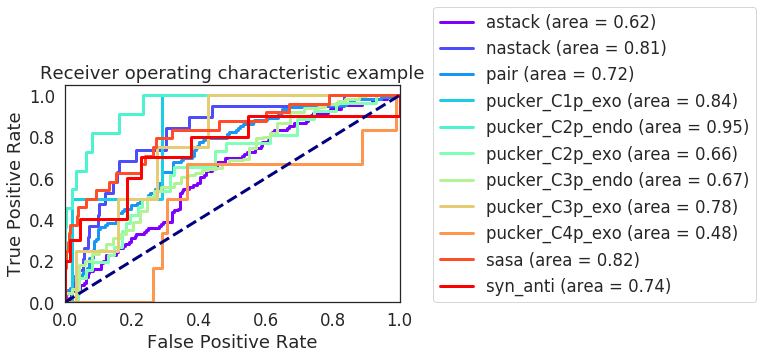

,id,resid,sasa,sasa,astack,nastack,pair,syn_anti,pucker_C2p_endo,pucker_C3p_endo,pucker_C2p_exo,pucker_C3p_exo,pucker_C1p_exo,pucker_C4p_exo,pastack,pnastack,ppair,ppucker_C1p_exo,ppucker_C2p_endo,ppucker_C2p_exo,ppucker_C3p_endo,ppucker_C3p_exo,ppucker_C4p_exo,psasa,psyn_anti
279,5KH8,43,183.51,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.725117,0.000082,0.588342,3.403920e-07,0.215723,0.306693,0.612118,0.007732,0.512214,0.352592,1.757448e-03
280,5KH8,44,180.49,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.354524,0.009179,0.326662,1.211375e-05,0.157825,0.457723,0.486264,0.002975,0.565263,0.558465,1.449380e-04
281,5KH8,45,163.27,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.548085,0.066913,0.468874,1.209727e-09,0.031965,0.209974,0.694067,0.030673,0.431081,0.390296,1.385608e-06
282,5KH8,46,188.07,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.617859,0.824933,0.534242,9.654343e-20,0.230739,0.592940,0.663439,0.000052,0.231041,0.521672,3.959673e-08
283,5KH8,47,338.68,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.389035,0.000176,0.700780,3.749771e-35,0.263581,0.455845,0.611243,0.016825,0.496183,0.999758,1.286099e-22


In [0]:
model = dc.models.ProgressiveMultitaskClassifier(n_tasks=n_tasks,n_features=n_features,layer_sizes=[100],alpha_init_stddevs=0.04,learning_rate=0.001)
model.fit(train_dataset_balanced, nb_epoch=50)

colors = cm.rainbow(np.linspace(0, 1, len(targets)))
testpred = model.predict(test_dataset_norm) 
plt.figure()
lw = 3

# get TPR and FPR
for i,target in enumerate(targets):
  fpr, tpr, thresholds = roc_curve(test_dataset_norm.y[:, i], testpred[:, i, 1].flatten())
  roc_auc = auc(fpr, tpr)
  # Make plot
  plt.plot(fpr, tpr, color=colors[i],lw=lw, label='%s (area = %0.2f)' % (target, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc=(1.1,0))
plt.show()


info = pd.read_csv(DIR_PATH+"info.csv", delim_whitespace=True, header=0)
actuals = pd.read_csv(DIR_PATH+"actuals.csv", delim_whitespace=True, header=0)
predictions = pd.DataFrame(testpred[:, :, 1], columns=["p"+i for i in targets])
predictions = pd.concat([info, actuals, predictions], axis=1)
predictions.to_csv(DIR_PATH+'deepchem_testset_predictions.txt', sep = ' ')
predictions.tail()

In [0]:
recall1=[]
recall0=[]
balanced_accuracys=[]
for i,target in enumerate(targets):
  recall1.append(recall_score(test_dataset_norm.y[:, i], testpred[:, i, 1].flatten()>=0.5))
  recall0.append(recall_score(test_dataset_norm.y[:, i], testpred[:, i, 1].flatten()>=0.5,pos_label=0))
  balanced_accuracys.append(balanced_accuracy_score(test_dataset_norm.y[:, i], testpred[:, i, 1].flatten()>=0.5)) 
test_stats = pd.DataFrame({'sensitivity': recall1, 'specificity':recall0, 'balanced accuracy':balanced_accuracys})
test_stats.index = targets
test_stats.round(3)

,balanced accuracy,sensitivity,specificity
astack,0.605,0.698,0.511
nastack,0.759,0.737,0.781
pair,0.655,0.794,0.516
pucker_C1p_exo,0.668,0.500,0.837
pucker_C2p_endo,0.852,0.909,0.795
pucker_C2p_exo,0.651,0.615,0.686
pucker_C3p_endo,0.597,0.643,0.551
pucker_C3p_exo,0.580,0.250,0.911
pucker_C4p_exo,0.635,0.667,0.604
sasa,0.735,0.708,0.762


In [0]:
predictions['syn_anti'].value_counts()

0.0    274
1.0     10
Name: syn_anti, dtype: int64

### Analyze deepchem testing result

In [0]:
print(confusion_matrix(predictions[predictions['id']=='5KH8']['pair'],predictions[predictions['id']=='5KH8']['ppair']>=0.5))

[[ 9  4]
 [ 6 28]]


In [0]:
predictions[predictions['id']=='5KH8']['pair'].value_counts()

1.0    34
0.0    13
Name: pair, dtype: int64